# **========== Install Liberary ==========**

In [1]:
!pip install transformers scikit-learn matplotlib seaborn
!pip install sastrawi


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


# **# ========== 1. Load Dataset ==========**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = ('/content/drive/MyDrive/DATASET_20k.csv')
df = pd.read_csv(file_path)
df['label'] = df['hoax']


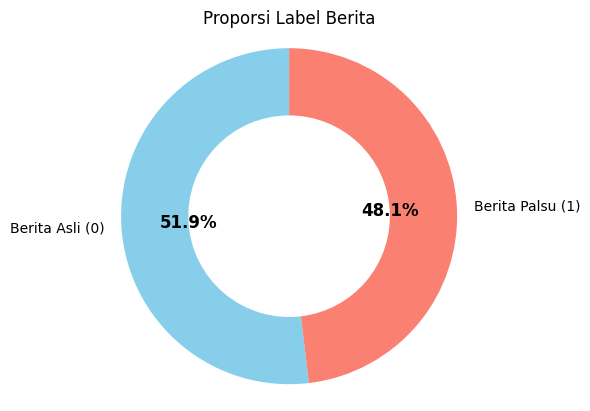

In [4]:
import matplotlib.pyplot as plt

# Hitung proporsi label Hoax (0 = asli, 1 = palsu)
label_counts = df['label'].value_counts(normalize=True) * 100
labels = ['Berita Asli (0)', 'Berita Palsu (1)']
colors = ['skyblue', 'salmon']

# Donut chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(label_counts, labels=labels, colors=colors,
                                  autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))

ax.set_title('Proporsi Label Berita')
plt.setp(autotexts, size=12, weight="bold")
plt.axis('equal')  # Circle
plt.show()


# **Preprocessing**

In [5]:
# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Ubah ke huruf kecil
    text = re.sub(r'\[.*?\]', '', text)             # Hapus kata dalam []
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Hapus karakter selain huruf
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text


In [6]:
# Simpan teks asli untuk perbandingan
df['original_text'] = df['text']

# Terapkan preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Tampilkan 5 contoh hasil sebelum dan sesudah
print(df[['original_text', 'text']].sample(5, random_state=42))


                                           original_text  \
18502  [SALAH] “BUS PEMAIN TIMNAS BRASIL  DILEMPARI B...   
5975   [HOAX] Pegawai Honorer K2 Meninggal Dunia Saat...   
9690       [SALAH] “Setelah difucksin, otak jadi Lelet”    
9877   Pemerintah dan DPR Bahas RUU Bali, Soroti Penu...   
3263   Kuasa Hukum: KPUD Kembali Diintimidasi Usai La...   

                                                    text  
18502  bus pemain timnas brasil dilempari batu suppor...  
5975   pegawai honorer k meninggal dunia saat demo di...  
9690                   setelah difucksin otak jadi lelet  
9877   pemerintah dan dpr bahas ruu bali soroti penur...  
3263   kuasa hukum kpud kembali diintimidasi usai lap...  


# **========== 2. Load IndoBERT ==========**

In [7]:
# Install library jika belum
!pip install transformers tqdm

# Import semua yang diperlukan
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
import pandas as pd

In [8]:
# 3. Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
model.eval()  # Set ke eval mode

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# **========== 3. Embedding ==========**

In [9]:
import numpy as np

def get_bert_embeddings(text_list, batch_size=8, max_length=512, save_path=None):
    all_embeddings = []
    model.eval()  # pastikan model dalam mode evaluasi
    with torch.no_grad():
        for i in tqdm(range(0, len(text_list), batch_size), desc="Generating embeddings"):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(embeddings)

    result = np.vstack(all_embeddings)

    # Simpan ke file jika diminta
    if save_path:
        np.save(save_path, result)
        print(f"Embedding disimpan ke: {save_path}.npy")

    return result


In [10]:
import torch

# Deteksi GPU jika ada, kalau tidak pakai CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pindahkan model ke device
model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
texts = df['text'].tolist()
labels = df['label'].values


In [14]:
X_embed = get_bert_embeddings(texts, batch_size=16, save_path="X_embed")
np.save("y_labels.npy", labels)


Generating embeddings: 100%|██████████| 1251/1251 [09:20<00:00,  2.23it/s]

Embedding disimpan ke: X_embed.npy


In [15]:
# Simpan hasil ke file (optional)
np.save('X_embed1.npy', X_embed)
np.save('y_labels1.npy', labels)

In [16]:
print("Jumlah teks yang diproses:", len(texts))
print("Dimensi hasil embedding:", X_embed.shape)  # (jumlah_data, dimensi_bert)


Jumlah teks yang diproses: 20011
Dimensi hasil embedding: (20011, 768)


# **====== 4. Pilih Train/Test Split atau K-Fold =======**

# **========== 5. Fungsi Prediksi Manual ==========**